# NHM d-score demo
This notebook demonstrates the basic d-score workflow for model evaluation applied to example NHM dataset.

A similar example from the National Assessment is on HyTest's [GitHub](https://github.com/hytest-org/workflow-2023-dscore-national-assessment/blob/master/national-assessment-dscore-demo.ipynb)

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../dependencies')

    
import pandas as pd
import numpy as np

from dscore import mse, stl, quantiles, seasons, bias_variability
from dscore import ilamb_score, scorecard_plot

In [2]:
import zipfile
from glob import glob

data_path = '../evaluation/example_data/'


# extract data
for f in glob(data_path + '*.zip'):
    with zipfile.ZipFile(f, 'r') as archive:
        #extract to notebook directory, or else set path=data_path
        archive.extractall(path='.') 


def load_csv(filename):
    '''Helper function to load csv data
    '''
    df = pd.read_csv(filename)
    df[['group','date','location']] =  df['Unnamed: 0'].str.split(':', expand=True)
    df = df.drop('Unnamed: 0', axis=1)

    return df


In [3]:
# load streamflow
df = load_csv('01473000.prior.csv')
data = df[df['group'] =='streamflow_mon']

data.head()

,modelled,measured,group,weight,standard_deviation,date,location
163460,13.37580,25.2581,streamflow_mon,4.140187,2.525806,2000_10,01472198
163461,12.72870,14.8774,streamflow_mon,7.028982,1.487742,2000_10,01472199
163462,6.79156,61.7742,streamflow_mon,0.000000,6.177419,2000_10,01472620
163463,50.88440,82.7419,streamflow_mon,1.263846,8.274194,2000_10,01472810
163464,195.41500,192.8060,streamflow_mon,0.542373,19.280646,2000_10,01473000


In [4]:
def compute_objective(data, obs, sim, objective, additive=True):
    '''Helper function to compute objective for each location
    '''
    groupby = 'location'
    scores = {
        'total' :  data.groupby(groupby).apply(lambda x: objective(x[obs], x[sim])),
        'bias-variance' : data.groupby(groupby).apply(lambda x: bias_variability(x[obs], x[sim],  objective=objective, additive=additive)),
        'quantiles' :  data.groupby(groupby).apply(lambda x: quantiles(x[obs], x[sim], objective=objective, additive=additive))
    }
        
    return pd.concat(scores, axis=1)

In [5]:
# streamflow analysis
log_data = data.copy()

# preprocessing
# clip negative values and transform to log
cols = ['modelled','measured']
log_data[cols] = np.log(data[cols].clip(lower=0.01))

log_data


,modelled,measured,group,weight,standard_deviation,date,location
163460,2.593447,3.229147,streamflow_mon,4.140187,2.525806,2000_10,01472198
163461,2.543859,2.699843,streamflow_mon,7.028982,1.487742,2000_10,01472199
163462,1.915681,4.123486,streamflow_mon,0.000000,6.177419,2000_10,01472620
163463,3.929556,4.415726,streamflow_mon,1.263846,8.274194,2000_10,01472810
163464,5.275126,5.261685,streamflow_mon,0.542373,19.280646,2000_10,01473000
...,...,...,...,...,...,...,...
164115,4.424112,2.744941,streamflow_mon,6.719053,1.556367,2010_9,01472198
164116,3.968936,2.389377,streamflow_mon,9.587999,1.090667,2010_9,01472199
164117,2.775266,3.605859,streamflow_mon,0.000000,3.681333,2010_9,01472620
164118,4.715064,3.947519,streamflow_mon,2.018526,5.180667,2010_9,01472810


In [6]:
# compute the objective and save results
streamflow_msle = compute_objective( log_data, 'measured', 'modelled', objective=mse)
streamflow_msle.to_csv("streamflow_msle.csv")

streamflow_msle.head()

total bias-variance             quantiles                      \
               MSE          bias variability       low below_avg above_avg   
location                                                                     
01472198  0.231191      0.085910    0.145281  0.099772  0.054486  0.042699   
01472199  0.121899      0.006614    0.115285  0.062720  0.033309  0.016583   
01472620  1.712619      0.942527    0.770092  0.144728  0.163243  0.362003   
01472810  0.269496      0.064154    0.205342  0.145097  0.060035  0.039159   
01473000  0.163015      0.015054    0.147961  0.077467  0.031774  0.024180   

                    
              high  
location            
01472198  0.034234  
01472199  0.009287  
01472620  1.042645  
01472810  0.025204  
01473000  0.029594

In [12]:
# post-processing
# work from the saved results to produce figures

from dscore import ilamb_score, percentage_score

# compute score by location
score = percentage_score(streamflow_msle,  name='NHM')
score

total bias-variance             quantiles                         
           MSE          bias variability       low below_avg above_avg high
location                                                                   
01472198   100            37          63        43        24        18   15
01472199   100             5          95        51        27        14    8
01472620   100            55          45         8        10        21   61
01472810   100            24          76        54        22        15    9
01473000   100             9          91        48        19        15   18

<Axes: ylabel='Component'>

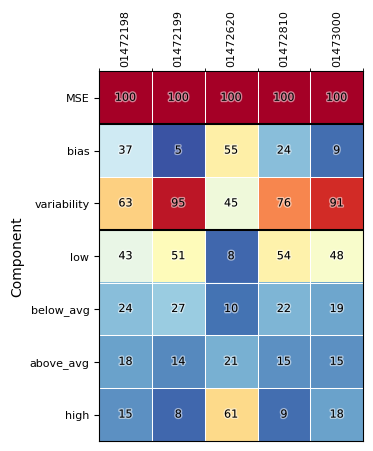

In [15]:
# Score by location (these could be aggregated in other ways, like by geographic region as done in the National Assessment example)
scorecard_plot(score.transpose(), cmap='RdYlBu_r')

<Axes: ylabel='Component'>

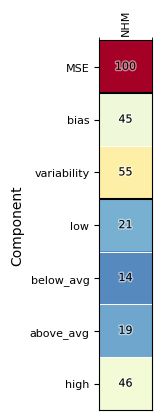

In [16]:
# Total Score
# Always aggregate data before taking the score
# Here, we take the mean msle, then score.
mean_score = percentage_score(streamflow_msle.mean(),  name='NHM')
scorecard_plot(mean_score, cmap='RdYlBu_r')

## ILAMB style score

In [ ]:
# could recompute msle using additive=False,
# but instead we'll accomplish the same affect with weights.
#streamflow_msle = compute_objective( log_data, 'measured', 'modelled', objective=mse, additive=False)

In [17]:
streamflow_msle

total bias-variance             quantiles                      \
               MSE          bias variability       low below_avg above_avg   
location                                                                     
01472198  0.231191      0.085910    0.145281  0.099772  0.054486  0.042699   
01472199  0.121899      0.006614    0.115285  0.062720  0.033309  0.016583   
01472620  1.712619      0.942527    0.770092  0.144728  0.163243  0.362003   
01472810  0.269496      0.064154    0.205342  0.145097  0.060035  0.039159   
01473000  0.163015      0.015054    0.147961  0.077467  0.031774  0.024180   

                    
              high  
location            
01472198  0.034234  
01472199  0.009287  
01472620  1.042645  
01472810  0.025204  
01473000  0.029594

In [19]:
var = log_data['measured'].var()

# If we divide the error into smaller and smaller pieces, the score for each piece will appear to get better and better
# smaller component -> smaller error -> better score
# There are a couple ways to adjust for that effect. Here we introduce a weighting based on the number of components in each decomp (1,2,4 in this case)
w = 1 / np.array([1,2,2,4,4,4,4])
v = var * w
# normalize the data then score
score = ilamb_score(streamflow_msle/v, a=3, name='NHM')
score

total bias-variance             quantiles                         
           MSE          bias variability       low below_avg above_avg high
location                                                                   
01472198    59            68          52        41        61        68   73
01472199    76            97          59        57        74        86   92
01472620     2             1           3        27        23         4    0
01472810    54            75          40        27        58        70   80
01473000    69            93          51        50        75        80   77

<Axes: ylabel='Component'>

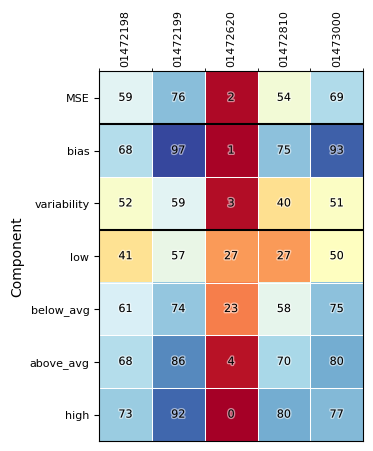

In [20]:
# yuck; technically you can plot this but I don't see this as too useful. I prefer maps here
scorecard_plot(score.transpose())

<Axes: ylabel='Component'>

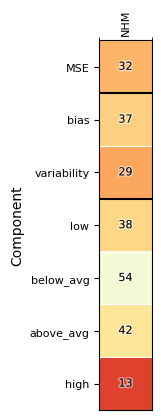

In [26]:
mean_score = ilamb_score(streamflow_msle.mean()/v, a=3, name='NHM')

scorecard_plot(mean_score)

Here we can see that one site dominates the score. There is a tempation to change the order of operations: score the sites, then take the mean, which would reduce the one-site affect.
But this that is very dangerous, because altering the `a` parameter can arbitrarily change the rankings of different sites or models. In other words, we loose any objective sense of good or bad performance. So in d-score, improvements at the other sites may not have as big an impact on the total score as we might like, but we can be sure that any improvement will yield a better score.

## Map example (TODO)
Mock up an example map of the NHM total score (MSLE).
This will be relatively easy to do. Refer to this National Assessment [notebook](https://github.com/hytest-org/workflow-2023-dscore-national-assessment/blob/master/national-assessment-dscore-demo.ipynb) for an example.

## Google style (TODO)
There are legitimate criticisms of the ILAMB scoring system. When done right (i.e., sticking to the order of operations espoused by dscore), ILAMB provides qualitative scores that are easy to visualize (quantitative scores are much harder to visualize, which has given rise to a wide range of techniques for colormap normalization. At it's heart, I think that's the right way to think about the ILAMB scoring: asthetic but useful. 

Recently I've noticed a paper out of Google that might offer a better balance of quantitative and asthetic in a scorecard. Their example uses RMSE, which is nice because it represents the typical error in familiar units (like degrees C). There are also good reasons not to use RMSE but for the sake of argument, but caveats aside, let's use it for this example.

The Google scorecard insight was to a meaningful score in the scorecard (i.e. RMSE) but color the cells using a normalized colormap. 

In [ ]:

streamflow_mse = compute_objective( data, 'measured', 'modelled', objective=mse, additive=False)
streamflow_rmse = np.sqrt(streamflow_mse)
streamflow_rmse